In [24]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import reproject
from reproject import reproject_interp
import radio_beam
from astropy.convolution import convolve_fft
from radio_beam import Beam, Beams
from photutils.aperture import SkyCircularAperture, aperture_photometry
from matplotlib.patches import Ellipse
from photutils.aperture import CircularAperture
import numpy as np
import matplotlib.pyplot as plt

Trabajamos con solo  2 imagenes para hacer el mapaeo de indice espectral

In [25]:
img1 = 'member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits'   # ~203 GHz
img3 = 'member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits'   # ~398 GHz
paths = [img1, img3]

In [26]:
#Pues este codigo me ayuda a saber cual tiene la peor resolucion

for p in paths:
    with fits.open(p) as h:
        H = h[0].header
        print(p, H['BMAJ']*3600, H['BMIN']*3600, H['BPA'])


member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits 0.16696010529993602 0.137572184205072 34.61054992676
member.uid___A001_X2df7_X600.B335_sci.spw25_27_29_31.cont.I.pbcor.fits 0.150284051895132 0.13160368800162 20.5141658783


Para este caso seria la imagen 1 

In [27]:

# donde img1 es la de menor resolucion
ref_path = img1

# Calcula área del beam de cada imagen 

with fits.open(ref_path) as hdul_ref:
    hdr_ref  = hdul_ref[0].header
    wcs_ref  = WCS(hdr_ref).celestial
    data_ref = hdul_ref[0].data.squeeze()
    beam_ref = Beam(major=hdr_ref['BMAJ']*u.deg, minor=hdr_ref['BMIN']*u.deg, pa=hdr_ref['BPA']*u.deg)
    

for p in paths:
    with fits.open(p) as h:
        H = h[0].header
        beams.append(Beam(major=H['BMAJ']*u.deg, minor=H['BMIN']*u.deg, pa=H['BPA']*u.deg))

# Extrae arrays separados de los componentes angulares
majors = [b.major.to(u.deg) for b in beams]
minors = [b.minor.to(u.deg) for b in beams]
pas    = [b.pa.to(u.deg)    for b in beams]

# Crea la colección directamente a partir de los componentes
beam_collection = Beams(major=majors, minor=minors, pa=pas, default_unit=u.deg)

# Calcula el beam común
common = beam_collection.common_beam()

print("Common beam:", common)





Common beam: Beam: BMAJ=0.16696010529993602 arcsec BMIN=0.137572184205072 arcsec BPA=34.61054992676 deg


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## 2) WCS/shape de referencia (de img1) + pixscale de esa grilla



In [28]:

with fits.open(ref_path) as hdul_ref:
    hdr_ref = hdul_ref[0].header
    wcs_ref = WCS(hdr_ref).celestial
    data_ref = hdul_ref[0].data.squeeze()
    shape_out = data_ref.shape

# pixscale de la grilla FINAL (para construir el kernel en pixeles)
pixscale_ref = np.sqrt(abs(hdr_ref['CDELT1'] * hdr_ref['CDELT2'])) * u.deg
print(pixscale_ref)

7.222222217153e-06 deg


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## Convoluciono y trabajo en la misma grilla

In [29]:
conv_images = []
EPS = 1e-3  # tolerancia


for p, b in zip(paths, beams):
    with fits.open(p) as hdul:
        H = hdul[0].header
        D = hdul[0].data.squeeze()
        wcs_in = WCS(H).celestial

        # (a) Regrid / reproject a la grilla de referencia
        D_rep, footprint = reproject_interp(
            (D, wcs_in),
            wcs_ref,
            shape_out=shape_out,
            order='bilinear'
        )


    if common.sr > b.sr * (1.0 + EPS):
        # kernel que lleva b -> common
        kern_beam = common.deconvolve(b)
        pixscale = np.sqrt(abs(H['CDELT1'] * H['CDELT2'])) * u.deg
        kernel = kern_beam.as_kernel(pixscale_ref)

        # convolve (NO renormalizar de nuevo el kernel)
        D_conv = convolve_fft(
            D_rep, kernel,
            boundary='fill', fill_value=np.nan,
            nan_treatment='interpolate',
            preserve_nan=True, allow_huge=True,
            normalize_kernel=False
        )

        #  cambiar unidades a Jy/beam_common, si no hago esto se descompone bien feo, feo feo.
        scale = (common.sr / b.sr).to_value(u.dimensionless_unscaled)
        D_conv *= scale

    else:
        # ya está en el haz común (o mayor dentro de EPS)
        D_conv = D_rep  # y scale ~ 1
        print(f"El beam de {p} ya es más grande o igual; no se convoluciona.")
    conv_images.append(D_conv)
    


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


El beam de member.uid___A001_X2d20_X35a9.B335_sci.spw17_19_21_23.cont.I.pbcor.fits ya es más grande o igual; no se convoluciona.


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## Generando el index spectral map

In [30]:
from astropy.stats import sigma_clipped_stats
import numpy as np
I1 = conv_images[0].astype(float)
I2 = conv_images[1].astype(float)

# Frecuencias (Hz)
nu1 = 203e9
nu2 = 398e9
ln_nu = np.log(nu2/nu1)

# Para I1
mean1, med1, std1 = sigma_clipped_stats(I1, sigma=3.0, maxiters=5, cenfunc='median', stdfunc='std')
k = 0.5
mask_bg1 = np.isfinite(I1) & (I1 < (med1 + k*std1))
rms1 = np.nanstd(I1[mask_bg1])

# Para I2
mean2, med2, std2 = sigma_clipped_stats(I2, sigma=3.0, maxiters=5, cenfunc='median', stdfunc='std')
mask_bg2 = np.isfinite(I2) & (I2 < (med2 + k*std2))
rms2 = np.nanstd(I2[mask_bg2])

print("rms1, rms2 =", rms1, rms2)


rms1, rms2 = 0.00011009562460948146 0.0009056625998762017


In [31]:
nu1 = 203e9
nu2 = 398e9
ln_nu = np.log(nu2/nu1)

nsig =2.0  # 3–5 típico
mask = (
    np.isfinite(I1) & np.isfinite(I2) &
    (I1 > nsig*rms1) & (I2 > nsig*rms2) &
    (I1 > 0) & (I2 > 0)
)

alpha = np.full(I1.shape, np.nan, dtype=float)
alpha[mask] = np.log(I2[mask]/I1[mask]) / ln_nu


## Grafica

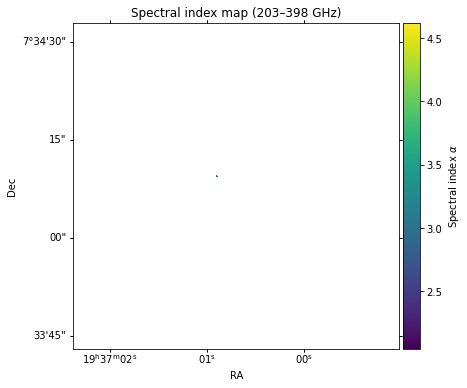

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# alpha ya calculado
vmin, vmax = np.nanpercentile(alpha, [1, 99])  

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(projection=wcs_ref) 
im = ax.imshow(alpha, origin="lower", vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, ax=ax, pad=0.01)
cb.set_label(r"Spectral index $\alpha$")

ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.set_title("Spectral index map (203–398 GHz)")
plt.show()


<ipython-input-33-9d466024e44b>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis").copy()


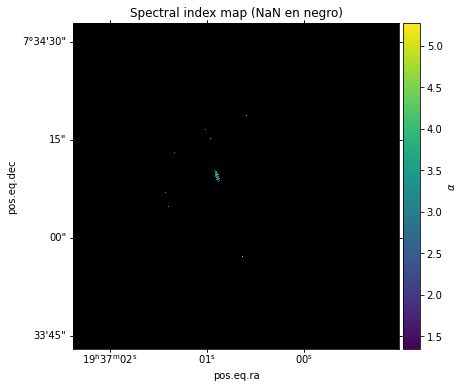

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cmap = cm.get_cmap("viridis").copy()
cmap.set_bad("black")

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(projection=wcs_ref)
im = ax.imshow(alpha, origin="lower", cmap=cmap, interpolation="nearest")
plt.colorbar(im, ax=ax, pad=0.01, label=r"$\alpha$")
ax.set_title("Spectral index map (NaN en negro)")
plt.show()


<ipython-input-34-7a5915cbae87>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis").copy()


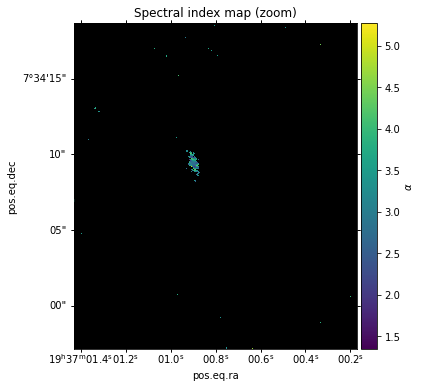

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

cmap = cm.get_cmap("viridis").copy()
cmap.set_bad("black")

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(projection=wcs_ref)
im = ax.imshow(alpha, origin="lower", cmap=cmap, interpolation="nearest")
plt.colorbar(im, ax=ax, pad=0.01, label=r"$\alpha$")

yy, xx = np.where(np.isfinite(alpha))
if len(xx) > 0:
    pad = 0.4
    ax.set_xlim(max(xx.min()-pad,0), min(xx.max()+pad, alpha.shape[1]-1))
    ax.set_ylim(max(yy.min()-pad,0), min(yy.max()+pad, alpha.shape[0]-1))

ax.set_title("Spectral index map (zoom)")
plt.show()


## Otras imagenes 
Siempre de B335

In [35]:
img2 = 'member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits'  # ~203 GHz 
img4 = 'member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits'                # ~398 GHz 
paths = [img2, img4]
# donde img1 es la de menor resolucion
ref_path = img4

# Calcula área del beam de cada imagen 

with fits.open(ref_path) as hdul_ref:
    hdr_ref  = hdul_ref[0].header
    wcs_ref  = WCS(hdr_ref).celestial
    data_ref = hdul_ref[0].data.squeeze()
    beam_ref = Beam(major=hdr_ref['BMAJ']*u.deg, minor=hdr_ref['BMIN']*u.deg, pa=hdr_ref['BPA']*u.deg)
    
for p in paths:
    with fits.open(p) as h:
        H = h[0].header
        print(p, H['BMAJ']*3600, H['BMIN']*3600, H['BPA'])


beams = []
for p in paths:
    with fits.open(p) as h:
        H = h[0].header
        beams.append(Beam(major=H['BMAJ']*u.deg, minor=H['BMIN']*u.deg, pa=H['BPA']*u.deg))

# Extrae arrays separados de los componentes angulares
majors = [b.major.to(u.deg) for b in beams]
minors = [b.minor.to(u.deg) for b in beams]
pas    = [b.pa.to(u.deg)    for b in beams]

# Crea la colección directamente a partir de los componentes
beam_collection = Beams(major=majors, minor=minors, pa=pas, default_unit=u.deg)

# Calcula el beam común
common = beam_collection.common_beam()

print("Common beam:", common)

member.uid___A001_X2d20_X35ab.B335_sci.spw17_19_21_23.cont.I.selfcal.tt0.pbcor.fits 0.5943149328232801 0.4268129169942 -38.30741882324
member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits 0.7608733177186799 0.63321048021312 -54.66566848755
Common beam: Beam: BMAJ=0.7608733177186799 arcsec BMIN=0.63321048021312 arcsec BPA=-54.66566848755 deg


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [36]:
with fits.open(ref_path) as hdul_ref:
    hdr_ref = hdul_ref[0].header
    wcs_ref = WCS(hdr_ref).celestial
    data_ref = hdul_ref[0].data.squeeze()
    shape_out = data_ref.shape

# pixscale de la grilla FINAL (para construir el kernel en pixeles)
pixscale_ref = np.sqrt(abs(hdr_ref['CDELT1'] * hdr_ref['CDELT2'])) * u.deg
print(pixscale_ref)

3.611111108576e-05 deg


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [37]:
conv_images = []
EPS = 1e-3  # tolerancia


for p, b in zip(paths, beams):
    with fits.open(p) as hdul:
        H = hdul[0].header
        D = hdul[0].data.squeeze()
        wcs_in = WCS(H).celestial

        # (a) Regrid / reproject a la grilla de referencia
        D_rep, footprint = reproject_interp(
            (D, wcs_in),
            wcs_ref,
            shape_out=shape_out,
            order='bilinear'
        )


    if common.sr > b.sr * (1.0 + EPS):
        # kernel que lleva b -> common
        kern_beam = common.deconvolve(b)
        pixscale = np.sqrt(abs(H['CDELT1'] * H['CDELT2'])) * u.deg
        kernel = kern_beam.as_kernel(pixscale_ref)

        # convolve (NO renormalizar de nuevo el kernel)
        D_conv = convolve_fft(
            D_rep, kernel,
            boundary='fill', fill_value=np.nan,
            nan_treatment='interpolate',
            preserve_nan=True, allow_huge=True,
            normalize_kernel=False
        )

        #  cambiar unidades a Jy/beam_common, si no hago esto se descompone bien feo, feo feo.
        scale = (common.sr / b.sr).to_value(u.dimensionless_unscaled)
        D_conv *= scale

    else:
        # ya está en el haz común (o mayor dentro de EPS)
        D_conv = D_rep  # y scale ~ 1
        print(f"El beam de {p} ya es más grande o igual; no se convoluciona.")
    conv_images.append(D_conv)
    


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


El beam de member.uid___A001_X2df7_X602.B335_sci.spw25_27_29_31.cont.I.pbcor.fits ya es más grande o igual; no se convoluciona.


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [38]:


I1 = conv_images[0].astype(float)
I2 = conv_images[1].astype(float)

# Frecuencias (Hz)
nu1 = 203e9
nu2 = 398e9
ln_nu = np.log(nu2/nu1)

# Para I1
mean1, med1, std1 = sigma_clipped_stats(I1, sigma=3.0, maxiters=5, cenfunc='median', stdfunc='std')
k = 1.0
mask_bg1 = np.isfinite(I1) & (I1 < (med1 + k*std1))
rms3 = np.nanstd(I1[mask_bg1])

# Para I2
mean2, med2, std2 = sigma_clipped_stats(I2, sigma=3.0, maxiters=5, cenfunc='median', stdfunc='std')
mask_bg2 = np.isfinite(I2) & (I2 < (med2 + k*std2))
rms4 = np.nanstd(I2[mask_bg2])

print("rms3, rms4 =", rms3, rms4)


rms3, rms4 = 0.000180724030278109 0.0027978032170936076


In [39]:
nu1 = 203e9
nu2 = 398e9
ln_nu = np.log(nu2/nu1)

nsig =3.0  # 3–5 típico
mask = (
    np.isfinite(I1) & np.isfinite(I2) &
    (I1 > nsig*rms3) & (I2 > nsig*rms4) &
    (I1 > 0) & (I2 > 0)
)

alpha = np.full(I1.shape, np.nan, dtype=float)
alpha[mask] = np.log(I2[mask]/I1[mask]) / ln_nu

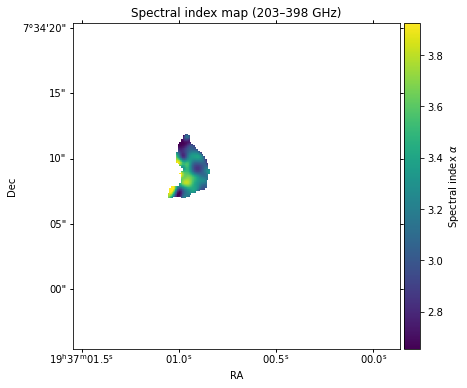

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# alpha ya calculado
vmin, vmax = np.nanpercentile(alpha, [2, 98]) 

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(projection=wcs_ref)  
im = ax.imshow(alpha, origin="lower", vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, ax=ax, pad=0.01)
cb.set_label(r"Spectral index $\alpha$")

ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.set_title("Spectral index map (203–398 GHz)")
plt.show()


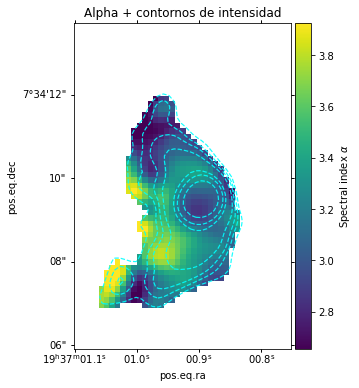

In [66]:

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(projection=wcs_ref)  
im = ax.imshow(alpha, origin="lower", vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, ax=ax, pad=0.01)
cb.set_label(r"Spectral index $\alpha$")
niveles = [3, 4, 5, 7, 15, 20, 30]  # en sigmas
levels_sigma = [n * rms4 for n in niveles]

ax.contour(Iref,levels=levels_sigma,colors="cyan",linewidths=1.2,alpha=0.9,linestyles="dashed",origin="lower")
ax.set_title("Alpha + contornos de intensidad")
plt.xlim(50,90)
plt.ylim(80,140)
plt.show()